In [1]:
#!pip install ultralytics

In [1]:
!yolo checks

Ultralytics YOLOv8.0.159  Python-3.8.6 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050, 8191MiB)
Setup complete  (12 CPUs, 15.9 GB RAM, 746.4/931.4 GB disk)


In [1]:
from ultralytics import YOLO
import os
import torch
import cv2 as cv
import cv2
import glob
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
#loading the model we will train
model = YOLO('yolov8n.pt')
animals_to_detect = ["Cheetah","Crocodile","Elephant","Giraffe","Hippopotamus","Leopard","Lion","Monkey","Rhinoceros","Tiger","Zebra"]

In [41]:
# the following few code blocks are just for seperating the data and processing images and labels.
# os.mkdir("yolo")
# os.mkdir("yolo/train")
# os.mkdir("yolo/train/images")
# os.mkdir("yolo/train/labels")
# os.mkdir("yolo/test")
# os.mkdir("yolo/test/images")
# os.mkdir("yolo/test/labels")
# os.mkdir("yolo/val")
# os.mkdir("yolo/val/images")
# os.mkdir("yolo/val/labels")


In [32]:
train_dir = "Animals_dataset/train"
test_dir = "Animals_dataset/test"


In [19]:
import cv2

# Load the image
image = cv2.imread('Animals_dataset/test/Elephant/2b3dcc603147288c.jpg')

# Get the resolution
height, width = image.shape[:2]

# Calculate new dimensions for resizing
# new_width = 640
# new_height = int((new_width / width) * height)
#
# # Resize the image
# resized_image = cv2.resize(image, (new_width, new_height))
# #cv2.imshow(resized_image)
# # Optionally, save the resized image
# cv2.imwrite('resized_image.jpg', resized_image)
# imgplot = plt.imshow(resized_image)
# plt.show()
print(height)
print(width)
#this was just to check the image sizes (after our first meeting), the images seem to all be different size, with one side being 1024 and the other side being radom

768
1024


In [31]:
#some general EDA
all_train_subdir=[]
all_test_subdir = []
for animal in animals_to_detect:
    all_train_subdir.append(train_dir+"/"+animal)
    all_test_subdir.append(test_dir+"/"+animal)



train_classes=[os.path.basename(path) for path in all_train_subdir]
test_classes=[os.path.basename(path) for path in all_test_subdir]

print("There is %d classes in train dataset, and %d classes in test dataset"%(len(animals_to_detect), len(animals_to_detect)))

train_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_train_subdir}
test_image_counts={os.path.basename(path):[len(glob.glob(os.path.join(path, "*.jpg")))] for path in all_test_subdir}

train_data_df = pd.DataFrame(train_image_counts, index=["train"]).transpose()
test_data_df = pd.DataFrame(test_image_counts, index=["test"]).transpose()
all_data_df=train_data_df.copy()
all_data_df["test"]=test_data_df
all_data_df
#print(all_train_subdir)


There is 11 classes in train dataset, and 11 classes in test dataset


,train,test
Cheetah,132,35
Crocodile,108,76
Elephant,155,33
Giraffe,298,23
Hippopotamus,76,22
Leopard,123,57
Lion,208,100
Monkey,770,321
Rhinoceros,214,34
Tiger,313,26


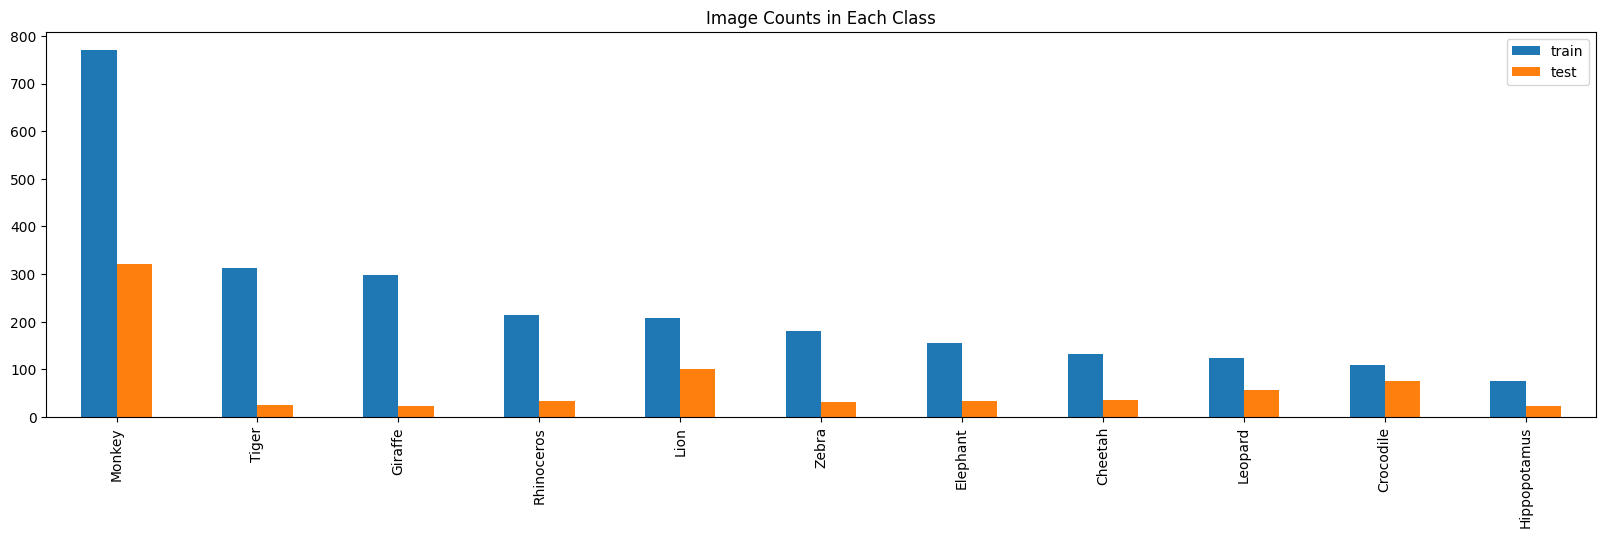

In [32]:
all_data_df=all_data_df.sort_values(by=["train","test"], ascending=False)
all_data_df.plot(kind="bar", legend=True, figsize=(20,5), title="Image Counts in Each Class");

In [42]:
#data processing and making train test val splits
validation_percentage = 0.2
for animal_name in animals_to_detect:
    image_file_names = os.listdir(train_dir + "/" + animal_name)

    # Calculate the number of images for the validation set
    num_validation_images = int(len(image_file_names) * validation_percentage)

    for i in range(len(image_file_names)):
        if image_file_names[i] != "Label":
            img = cv2.imread(train_dir + "/" + animal_name + "/" + image_file_names[i], cv2.IMREAD_COLOR)

            if i <= num_validation_images:
                # If the current image is not in the validation set, save it to the training set
                cv2.imwrite("yolo/train/images/" + image_file_names[i], img)
            else:
                # If the current image is in the validation set, save it to the validation set
                cv2.imwrite("yolo/val/images/" + image_file_names[i], img)

    image_file_name = os.listdir(test_dir+"/"+animal_name)
    for i in range(0,len(image_file_name)):
            if image_file_name[i] != "Label":
                img = cv2.imread(test_dir+"/"+animal_name+"/"+image_file_name[i], cv2.IMREAD_COLOR)
                #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                cv2.imwrite("yolo/test/images/"+image_file_name[i], img)

In [8]:
# import shutil
#
# for animal_name in animals_to_detect:
#     label_file_name = os.listdir(train_dir+"/"+animal_name+"/Label")
#     for i in range(0,len(label_file_name)):
#             shutil.copy(train_dir+"/"+animal_name+"/Label/"+label_file_name[i],"yolo/train/labels")
#
#     label_file_name = os.listdir(test_dir+"/"+animal_name+"/Label")
#     for i in range(0,len(label_file_name)):
#             shutil.copy(test_dir+"/"+animal_name+"/Label/"+label_file_name[i],"yolo/test/labels")

In [38]:
animals_encoding = {"Cheetah":0,"Crocodile":1,"Elephant":2,"Giraffe":3,"Hippopotamus":4,"Leopard":5,"Lion":6,"Monkey":7,"Rhinoceros":8,"Tiger":9,"Zebra":10}

In [43]:
def process_files(input_files_path, output_files_path, is_validation=False):
    for animal_specie in animals_to_detect:
        txt_file_name = os.listdir(input_files_path + "/" + animal_specie + "/Label")
        num_txt_files = len(txt_file_name)
        if is_validation:
            # Calculate the number of files to put in the validation set
            start_index = int(num_txt_files * validation_percentage)
        else:
            start_index = 0

        for i in range(start_index, num_txt_files):
            with open(input_files_path + "/" + animal_specie + "/Label/" + txt_file_name[i], "r") as source:
                with open(output_files_path + "/" + txt_file_name[i], "w") as destination:
                    image_file_name_no_ext = txt_file_name[i][0:len(txt_file_name[i]) - 4]
                    img = cv2.imread(input_files_path + "/" + animal_specie + "/" + image_file_name_no_ext + ".jpg", cv2.IMREAD_COLOR)
                    height = img.shape[0]
                    width = img.shape[1]
                    for line in source:
                        labeling_data = line.split()
                        labeling_data[0] = animals_encoding[labeling_data[0]]
                        xmin = float(labeling_data[1])
                        ymin = float(labeling_data[2])
                        xmax = float(labeling_data[3])
                        ymax = float(labeling_data[4])
                        cx = (xmin + xmax) / 2.0 / width
                        cy = (ymin + ymax) / 2.0 / height
                        box_width = (xmax - xmin) / width
                        box_height = (ymax - ymin) / height
                        destination.write(str(labeling_data[0]) + " ")
                        destination.write(str(cx) + " ")
                        destination.write(str(cy) + " ")
                        destination.write(str(box_width) + " ")
                        destination.write(str(box_height) + "\n")

In [44]:
process_files("Animals_dataset/train","yolo/train/labels")
process_files("Animals_dataset/test","yolo/test/labels")
process_files(train_dir, "yolo/val/labels", is_validation=True)

In [12]:
#creating yaml file and filling it in (the test.yaml file i made by hand as its just copying this and changing the val path)
# with open("animals.yaml", "w") as yaml_file:
#     yaml_file.write("path: AnimalTest/yolo "+"\n")
#     yaml_file.write("train: train/images "+"\n")
#     yaml_file.write("val: val/images"+"\n")
#     yaml_file.write("names:"+"\n")
#
#     yaml_file.write(" 0: Cheetah"+"\n")
#     yaml_file.write(" 1: Crocodile"+"\n")
#     yaml_file.write(" 2: Elephant"+"\n")
#     yaml_file.write(" 3: Giraffe"+"\n")
#     yaml_file.write(" 4: Hippopotamus"+"\n")
#     yaml_file.write(" 5: Leopard"+"\n")
#     yaml_file.write(" 6: Lion"+"\n")
#     yaml_file.write(" 7: Monkey"+"\n")
#     yaml_file.write(" 8: Rhinoceros"+"\n")
#     yaml_file.write(" 9: Tiger"+"\n")
#     yaml_file.write(" 10: Zebra"+"\n")


In [13]:
#random cuda checks, theres no need to leave this in but since 50% of the time spent on this project was me trying to get cuda to work so i can use my gpu to train the model im leaving it in :(
# Step 1: Check Pytorch (optional)

# print("Cuda available: ", torch.cuda.is_available())
# #print("Device name:", torch.cuda.get_device_name())
# # Step 2: Check Tensorflow
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# # Step 3: Check Keras (optional)
# from keras import backend as K
# print(K.tensorflow_backend._get_available_gpus())

In [45]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [ ]:
detection_model = model.train(data='animals.yaml', epochs=50, imgsz=640, workers=4)

In [16]:
#model = model.load(weights="runs/detect/train2/weights/best.pt")

In [2]:
model = YOLO("best.pt") #to load the model

In [4]:
results = model.val(data="test.yaml") #model testing

Ultralytics YOLOv8.0.159  Python-3.8.6 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050, 8191MiB)
val: Scanning E:\pycharm test\AnimalTest\yolo\test\labels... 724 images, 0 backgrounds, 0 corrupt: 100%|██████████| 724/724 [00:01<00:00, 395.66it/s] 
val: New cache created: E:\pycharm test\AnimalTest\yolo\test\labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:18<00:00,  2.47it/s]
                   all        724        830      0.811      0.776      0.812      0.685
               Cheetah        724          6      0.172        0.5      0.137      0.125
             Crocodile        724         81      0.947       0.88      0.966      0.742
              Elephant        724         39      0.705      0.718      0.779      0.627
               Giraffe        724         30      0.933        0.9      0.932       0.77
          Hippopotamus        724         32      0.929      0.656      0.823      0.638
    

In [3]:
results = model.predict(source="2", show=True, conf=0.63)
#to test it using webcam (the source probably needs to be set to 0 for a new computer, i use droid cam so its set to 2


1/1: 2... Success  (inf frames of shape 640x480 at 30.00 FPS)


    WARNING  stream/video/webcam/dir predict source will accumulate results in RAM unless `stream=True` is passed,
    causing potential out-of-memory errors for large sources or long-running streams/videos.

    Example:
        results = model(source=..., stream=True)  # generator of Results objects
        for r in results:
            boxes = r.boxes  # Boxes object for bbox outputs
            masks = r.masks  # Masks object for segment masks outputs
            probs = r.probs  # Class probabilities for classification outputs

0: 480x640 (no detections), 546.5ms
0: 480x640 (no detections), 14.0ms
0: 480x640 (no detections), 12.0ms
0: 480x640 (no detections), 12.0ms
0: 480x640 (no detections), 12.0ms
0: 480x640 (no detections), 11.0ms
0: 480x640 (no detections), 12.0ms
0: 480x640 (no detections), 11.0ms
0: 480x640 (no detections), 19.0ms
0: 480x640 (no detections), 10.0ms
0: 480x640 (no detections), 11.0ms
0: 480x640

KeyboardInterrupt: 

In [ ]:
#ovoj kod e za printanje na koordinatite na sekoja od kutiite, no ne bese voopsto prakticno bidejki samo ispagja spam na koordinati pa zatoa go koristam pogorniot kod
# cap = cv2.VideoCapture(2)
#
# # Loop through the video frames
# while cap.isOpened():
#     # Read a frame from the video
#     success, frame = cap.read()
#
#     if success:
#         # Run YOLOv8 inference on the frame
#         results = model.predict(frame, show=True, conf=0.5)
#
#         # for r in results:
#         #     boxes = r.boxes
#         #     for box in boxes:
#         #         x1, y1, x2, y2 = box.xyxy[0]
#         #         x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
#         #         print("Coordinates: ", x1, y1, x2, y2)
#         #Visualize the results on the frame
#         annotated_frame = results[0].plot()
#
#         #Display the annotated frame
#         cv2.imshow("YOLOv8 Inference", annotated_frame)
#
#         # Break the loop if 'q' is pressed
#         if cv2.waitKey(1) & 0xFF == ord("q"):
#             break
#     else:
#         # Break the loop if the end of the video is reached
#         break
#
# # Release the video capture object and close the display window
# cap.release()
# cv2.destroyAllWindows()